# **Chuẩn bị dữ liệu**

In [1]:
#Chạy hết các câu lệnh sau rồi Restart kernel

# !pip install torch==2.3.1 torchtext==0.18.0 torchdata==0.7.1 portalocker
# !pip install spacy
# !python -m spacy download en_core_web_sm
# !python -m spacy download de_core_news_sm
# !pip install nltk

## Import các thư viện cần thiết

In [2]:
import torchtext
import torch
from torchtext.datasets import Multi30k, multi30k
from torch.utils.data import Dataset
torchtext.disable_torchtext_deprecation_warning()

c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtext\datasets\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)
c:\Users\Admin\AppData\Local\Programs\Python\Python311\Lib\site-packages\torchtext\data\__init__.py:4: UserWarning: 
/!\ IMPORTANT WARNING ABOUT TORCHTEXT STATUS /!\ 
Torchtext is deprecated and the last released version will be 0.18 (this one). You can silence this warning by calling the following at the beginnign of your scripts: `import torchtext; torchtext.disable_torchtext_deprecation_warning()`
  warnings.warn(torchtext._TORCHTEXT_DEPRECATION_MSG)


## Load dataset

### Tìm và tải các datasets

Vì bị lỗi file test do server của multi30k đã sập, lấy file test và giải nén bị lỗi.

**Cách giải quyết:**
 - Vẫn dùng hàm Multi30k() -> Tải các file .gz từ Github về -> Giải nén ra thành file Text -> Đặt vào thư mục .data. Khi đó hàm Multi30k() sẽ thấy dữ liệu và sẵn sàng để hoạt động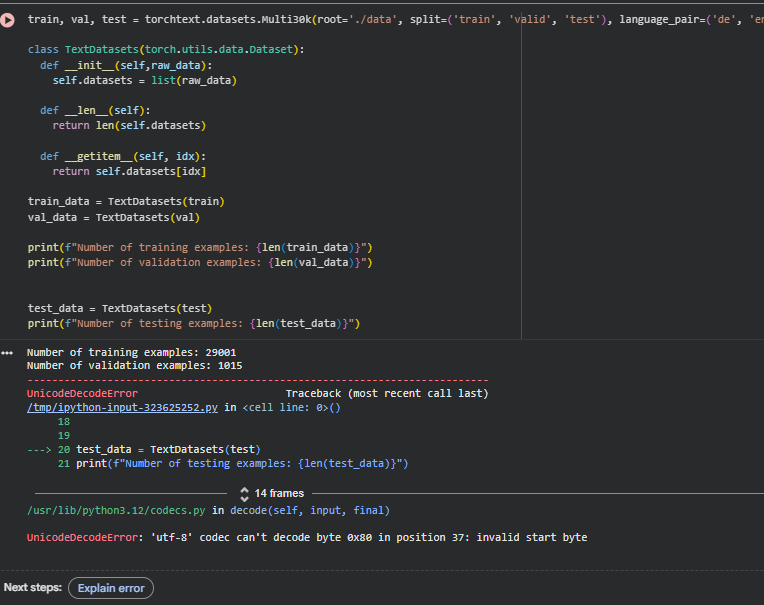

In [3]:
import os
import requests
import gzip #dùng để giải nén và nén thư mục
import shutil #dùng để copy file
#Xóa .data cũ và thay bằng folder mới
data_root = './data' #đường dẫn đến folder data trong google colab
#if os.path.exists(data_root):
#  !rm -rf {data_root} #Xóa đi folder data chứa data lỗi

os.makedirs(f"{data_root}/Multi30k",exist_ok=True) #Tạo lại folder data

#Link github để tải dataset
BASE_URL = "https://raw.githubusercontent.com/multi30k/dataset/master/data/task1/raw"
files_map = {
    "train.de.gz": "train.de",
    "train.en.gz": "train.en",
    "val.de.gz":   "val.de",
    "val.en.gz":   "val.en",
    #dùng tập test 2018
    "test_2018_flickr.de.gz": "test2018.de",
    "test_2018_flickr.en.gz": "test2018.en"
}

missing_file = False
for github_name, name in files_map.items():
  save_path = f"{data_root}/Multi30k/{name}" #Đường dẫn cho các file dataset
  if not os.path.exists(save_path): #Nếu folder có files thì không tải lại
    missing_file = True #set cờ để chạy
    response = requests.get(f"{BASE_URL}/{github_name}")
    if response.status_code == 200: #nếu status code == 200 thì request được
      content = gzip.decompress(response.content) #giải nén file dataset
      with open(save_path, "wb") as f: #mở file để ghi
        f.write(content)
    else:
      print(f"Lỗi yêu cầu đến {github_name}")

#copy lại các file test để backup
if not os.path.exists(f'{data_root}/Multi30k/test.de'):
  shutil.copy(f"{data_root}/Multi30k/test2018.de", f"{data_root}/Multi30k/test.de")
  shutil.copy(f"{data_root}/Multi30k/test2018.en", f"{data_root}/Multi30k/test.en")

### Đọc dữ liệu thành Text

In [4]:
from torch.utils.data import Dataset
import re #module xử lý chuỗi

#Hàm chuẩn hóa văn bản trước khi token
def normalize_string(s):
    s = s.lower().strip()
    # Tách dấu câu ra khỏi từ
    s = re.sub(r"([.!?])", r" \1", s)
    # Loại bỏ các ký tự lạ, chỉ giữ lại chữ cái và các dấu câu cơ bản (äöüß)
    s = re.sub(r"[^a-zA-ZäöüÄÖÜß.!?]+", r" ", s)
    return s

class ManualTextDataset(Dataset):
    def __init__(self, src, target):
        self.data = []

        # Kiểm tra file có tồn tại không
        if not os.path.exists(src) or not os.path.exists(target):
            raise FileNotFoundError(f"Missing {src} file or {target} file")

        print(f'Đọc {src} và {target}')
        # Mở 2 file cùng lúc và ghép dòng tương ứng
        with open(src, 'r', encoding='utf-8') as f_src, \
             open(target, 'r', encoding='utf-8') as f_trg:

            for line_src, line_trg in zip(f_src, f_trg):
                # Chỉ lấy nếu cả 2 dòng đều có chữ
                if line_src.strip() and line_trg.strip():
                    clean_src = normalize_string(line_src)
                    clean_trg = normalize_string(line_trg)
                    self.data.append((clean_src, clean_trg))

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data[idx]

In [5]:
print("Tạo Dataset: ")

train_datasets = ManualTextDataset(f"{data_root}/Multi30k/train.en", f"{data_root}/Multi30k/train.de")
valid_datasets = ManualTextDataset(f"{data_root}/Multi30k/val.en",   f"{data_root}/Multi30k/val.de")
test_datasets  = ManualTextDataset(f"{data_root}/Multi30k/test.en",  f"{data_root}/Multi30k/test.de")

print(f"Train size: {len(train_datasets)}")
print(f"Valid size: {len(valid_datasets)}")
print(f"Test size:  {len(test_datasets)}")

# Kiểm tra thử 1 mẫu
print(f"\nMẫu dữ liệu đầu tiên:\n {train_datasets[0]}")

Tạo Dataset: 
Đọc ./data/Multi30k/train.en và ./data/Multi30k/train.de
Đọc ./data/Multi30k/val.en và ./data/Multi30k/val.de
Đọc ./data/Multi30k/test.en và ./data/Multi30k/test.de
Train size: 29000
Valid size: 1014
Test size:  1071

Mẫu dữ liệu đầu tiên:
 ('two young white males are outside near many bushes .', 'zwei junge weiße männer sind im freien in der nähe vieler büsche .')


## Triển khai Tokenizer

In [6]:
from torchtext.data.utils import get_tokenizer
en_tokenizer = torchtext.data.utils.get_tokenizer('spacy', language='en_core_web_sm')
de_tokenizer = torchtext.data.utils.get_tokenizer('spacy', language='de_core_news_sm')

## Xây dựng từ điển cho mô hình

- Dùng build_vocab_iterator

- Thêm token đặc biệt: unk, pad, sos , eos

- Limit: 10k từ phổ biến nhất mỗi ngôn ngữ

In [7]:
from torchtext.vocab import build_vocab_from_iterator

#Hàm hỗ trợ tách chữ
def yield_tokens(data,tokenizer,dataset_index):
  for sample in data: #Lấy từng cặp câu trong data ra
    yield tokenizer(sample[dataset_index]) #Chọn ngôn ngữ và tách chữ (0 là Anh, 1 là Đức)

special_symbols = ['<unk>', '<pad>', '<sos>', '<eos>'] #token đặc biệt
UNK_IDX, PAD_IDX, SOS_IDX, EOS_IDX = 0, 1, 2, 3

#Source là Anh (index 0):
vocab_src = build_vocab_from_iterator(yield_tokens(train_datasets, en_tokenizer, 0),
                                      min_freq=3, specials=special_symbols, max_tokens=10000)

vocab_src.set_default_index(UNK_IDX)
#Set UNK_IDX là index mặc định. Index trả về khi không tìm thấy token.
#Nếu không set thì sẽ chạy ra lỗi RuntimeError khi mà không tìm thấy token trong Vocab

# Target là Đức (index 1)
vocab_target = build_vocab_from_iterator(yield_tokens(train_datasets, de_tokenizer, 1),
    min_freq=3, specials=special_symbols, max_tokens=10000)

vocab_target.set_default_index(UNK_IDX)

print(f"Vocab Source (Anh): {len(vocab_src)}")
print(f"Vocab Target (Đức): {len(vocab_target)}")

Vocab Source (Anh): 4534
Vocab Target (Đức): 5395


In [8]:
print(vocab_src.get_stoi())
print(vocab_target.get_stoi())

{'pitch': 1506, 'pouring': 996, 'wires': 1833, 'fruit': 509, 'point': 2173, '.': 5, 'woods': 437, 'little': 51, 'newspapers': 1791, '<unk>': 0, 'pushes': 934, 'skies': 2358, 'patient': 1565, 'lies': 1021, 'sing': 1201, 'street': 38, 'moped': 1495, 'in': 6, 'customers': 845, 'sheepdog': 3634, 'attire': 450, 'kicked': 2746, 'probably': 2797, 'soccer': 121, 'daily': 2453, '<eos>': 3, '<pad>': 1, 'crane': 1471, 'smoke': 1336, 'york': 1099, 'hiding': 2007, 'cowboy': 426, 'storage': 3690, 'company': 1856, 'metal': 304, 'green': 50, 'track': 299, 'pours': 2343, 'the': 7, 'crashes': 3926, 'face': 156, 'doll': 1764, 'garbage': 1114, 'workers': 225, 'winter': 443, 'taste': 3717, 'seems': 1199, 'outdoors': 338, 'her': 42, 'activity': 1958, 'hose': 830, 'group': 37, 'gentleman': 521, 'bald': 679, 'underway': 4487, 'a': 4, 'outside': 55, 'drivers': 3372, 'readying': 3592, 'jeans': 172, 'black': 25, 'to': 17, 'jungle': 1226, 'or': 255, 'all': 252, 'observes': 1715, 'i': 950, 'ball': 66, 'sandwich': 

## Padding

In [9]:
from torch.nn.utils.rnn import pad_sequence, pad_packed_sequence

def Text2ListNum(text,tokenizer,vocab,reverse=False):
  #Tách từ
  tokens = tokenizer(text.strip())
  if reverse:
    tokens = tokens[::1] # Đảo ngược thứ tự từ
  #format lại thêm SOS đầu, EOS cuối, và chuyển thành số ID lấy từ vocab ở trên
  return [SOS_IDX] + [vocab[token] for token in tokens] + [EOS_IDX]

def collate_fn(batch):
  """
  Input: List tuples [(src_1,target_1),(src_2, target_2),...]
  Output: padded Sourced, padded target, source lengths
  """
  #Khởi tạo mảng src và target
  src_batch, target_batch = [],[]
  #Vòng lặp chạy qua các câu trong batch
  for src_sample, target_sample in batch:

    src_tensor = torch.tensor(Text2ListNum(src_sample, en_tokenizer, vocab_src),
                              dtype=torch.long)
    target_tensor = torch.tensor(Text2ListNum(target_sample, de_tokenizer, vocab_target),
                              dtype=torch.long)

    src_batch.append(src_tensor)
    target_batch.append(target_tensor)

  #ghép lại thành cặp để đồng bộ sort không lệch
  combined = list(zip(src_batch, target_batch))
  #giảm dần theo chiều dài câu source
  combined.sort(key=lambda x: len(x[0]),reverse=True)
  #tách ra lại
  src_batch, target_batch = zip(*combined)

  src_len = torch.tensor([len(x) for x in src_batch])
  target_len = torch.tensor([len(x) for x in target_batch])

  src_batch = pad_sequence(src_batch, padding_value=PAD_IDX,batch_first=True)
  target_batch = pad_sequence(target_batch, padding_value=PAD_IDX,batch_first=True)

  return src_batch, target_batch, src_len, target_len

## DataLoader

In [10]:
from torch.utils.data import DataLoader
BATCH_SIZE = 128

train_loader = DataLoader(train_datasets, batch_size=BATCH_SIZE,
                          shuffle=True,collate_fn=collate_fn)
valid_loader = DataLoader(valid_datasets, batch_size=BATCH_SIZE,
                          shuffle=False,collate_fn=collate_fn)
test_loader = DataLoader(test_datasets, batch_size=BATCH_SIZE,
                          shuffle=False,collate_fn=collate_fn)

print("--- BẮT ĐẦU DUYỆT DATA ---")

# enumerate giúp đếm số thứ tự batch (i)
for i, (src, trg, src_len, tar_len) in enumerate(train_loader):

    print(f"\nBatch thứ {i}:")
    print(f" - Kích thước Src: {src.shape}")
    print(f" - Kích thước Trg: {trg.shape}")
    print(f" - Kích thước Src_len: {src_len.shape}")

    if i == 5:
        break

--- BẮT ĐẦU DUYỆT DATA ---

Batch thứ 0:
 - Kích thước Src: torch.Size([128, 26])
 - Kích thước Trg: torch.Size([128, 25])
 - Kích thước Src_len: torch.Size([128])

Batch thứ 1:
 - Kích thước Src: torch.Size([128, 34])
 - Kích thước Trg: torch.Size([128, 32])
 - Kích thước Src_len: torch.Size([128])

Batch thứ 2:
 - Kích thước Src: torch.Size([128, 31])
 - Kích thước Trg: torch.Size([128, 29])
 - Kích thước Src_len: torch.Size([128])

Batch thứ 3:
 - Kích thước Src: torch.Size([128, 29])
 - Kích thước Trg: torch.Size([128, 27])
 - Kích thước Src_len: torch.Size([128])

Batch thứ 4:
 - Kích thước Src: torch.Size([128, 31])
 - Kích thước Trg: torch.Size([128, 33])
 - Kích thước Src_len: torch.Size([128])

Batch thứ 5:
 - Kích thước Src: torch.Size([128, 31])
 - Kích thước Trg: torch.Size([128, 29])
 - Kích thước Src_len: torch.Size([128])



A module that was compiled using NumPy 1.x cannot be run in
NumPy 2.2.4 as it may crash. To support both 1.x and 2.x
versions of NumPy, modules must be compiled with NumPy 2.0.
Some module may need to rebuild instead e.g. with 'pybind11>=2.12'.

If you are a user of the module, the easiest solution will be to
downgrade to 'numpy<2' or try to upgrade the affected module.
We expect that some modules will need time to support NumPy 2.

Traceback (most recent call last):  File "<frozen runpy>", line 198, in _run_module_as_main
  File "<frozen runpy>", line 88, in _run_code
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\ipykernel_launcher.py", line 18, in <module>
    app.launch_new_instance()
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\traitlets\config\application.py", line 1075, in launch_instance
    app.start()
  File "C:\Users\Admin\AppData\Roaming\Python\Python311\site-packages\ipykernel\kernelapp.py", line 739, in start
    self.io_lo

# Triển khai và huấn luyện mô hình

## Xây dựng mô hình

In [11]:
import torch.nn as nn
from torch.nn.utils.rnn import pack_padded_sequence

class LSTMModel(nn.Module):
    def __init__(self, src_size, target_size, embed_dim, hidden_dim, lstm_layers=2, drop_out=0.3, t_ratio = 0.5):
        super().__init__()
        self.encoder_embedding = nn.Embedding(src_size, embedding_dim= embed_dim)
        self.encoder_lstm = nn.LSTM(embed_dim, hidden_dim, lstm_layer, batch_first=True, dropout= drop_out)

        self.decoder_embedding = nn.Embedding(target_size, embedding_dim= embed_dim)
        self.decoder_lstm = nn.LSTM(embed_dim, hidden_dim, lstm_layer, batch_first=True, dropout= drop_out)
        self.fc = nn.Linear(hidden_dim, target_size)

    def forward(self, src, tgt, src_lengths, tgt_lengths, teacher_forcing_ratio=0.5):

      # ===== ENCODER =====
      embedded_src = self.encoder_embedding(src)
      packed_src = pack_padded_sequence(
          embedded_src,
          src_lengths,
          batch_first=True,
          enforce_sorted=True
      )
      _, (h, c) = self.encoder_lstm(packed_src)


      # ===== DECODER =====
      batch_size = tgt.size(0)
      max_len    = tgt.size(1)
      vocab_size = self.fc.out_features

      # to store decoder outputs
      outputs = torch.zeros(batch_size, max_len, vocab_size, device=src.device)

      # first input to decoder = <BOS>
      input_token = tgt[:, 0]      # [batch]

      for t in range(1, max_len):

          # embed the input token
          input_embedded = self.decoder_embedding(input_token).unsqueeze(1)

          # decode one step
          output, (h, c) = self.decoder_lstm(input_embedded, (h, c))

          # predict token distribution
          logits = self.fc(output.squeeze(1))
          outputs[:, t, :] = logits

          # choose next input
          teacher_force = (torch.rand(1) < teacher_forcing_ratio)

          if teacher_force:
              # use ground-truth token
              input_token = tgt[:, t]
          else:
              # use model prediction
              input_token = logits.argmax(dim=-1)

      return outputs




## Hàm đánh giá

In [12]:
criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)

def compute_loss(logits, targets):
    # logits: [batch, seq_len, vocab_size]
    # targets: [batch, seq_len]

    logits = logits.reshape(-1, logits.size(-1))    # [B*T, vocab]
    targets = targets.reshape(-1)                   # [B*T]

    loss = criterion(logits, targets)
    return loss


In [13]:
def compute_accuracy(logits, targets):
    # logits: [batch, seq_len, vocab_size]
    pred = logits.argmax(dim=-1)  # [batch, seq_len]

    correct = (pred == targets).float().sum()
    total = targets.numel()

    acc = correct / total
    return acc.item()


In [14]:
import math
def compute_perplexity(loss):
    return math.exp(loss)


In [15]:
from nltk.translate.bleu_score import sentence_bleu, SmoothingFunction

# def compute_bleu(logits, targets):
#     return sentence_bleu([targets], logits)

def compute_bleu(logits, targets):
    """
    Tính BLEU score cho một batch.
    logits: [batch_size, seq_len, vocab_size]
    targets: [batch_size, seq_len]
    """
    # Chuyển Logits (xác suất) thành Index (số thứ tự từ)
    # Lấy ra từ có xác suất cao nhất tại mỗi vị trí
    preds = logits.argmax(dim=-1).tolist() 
    targets = targets.tolist()

    score = 0
    batch_size = len(targets)
    
    # Dùng hàm làm mượt để tránh bị điểm 0 khi câu quá ngắn
    smoothie = SmoothingFunction().method1 

    # Duyệt qua từng cặp câu trong batch
    for pred, target in zip(preds, targets):
        # Lọc bỏ các token đặc biệt (SOS, EOS, PAD)
        # Chỉ giữ lại nội dung chính để tính điểm cho công bằng
        pred_clean = [p for p in pred if p not in [SOS_IDX, EOS_IDX, PAD_IDX]]
        target_clean = [t for t in target if t not in [SOS_IDX, EOS_IDX, PAD_IDX]]

        # ==== Tính BLEU ==== 
        # Nếu model chưa học được gì và dự đoán rỗng -> 0 điểm
        if len(pred_clean) == 0:
            score += 0
        else:
            # NLTK yêu cầu references phải là list lồng nhau: [[ref]]
            score += sentence_bleu([target_clean], pred_clean, smoothing_function=smoothie)

    # Trả về trung bình cộng của cả batch
    return score / batch_size


## Định tham số mô hình

In [16]:
hidden_size = 512
embedding_dim = 256
lstm_layer = 2
drop_out = 0.3
teacher_forcing_ratio = 0.5

## Khời tạo mô hình

In [17]:
import torch
from torch.optim import Adam

model = LSTMModel(len(vocab_src), len(vocab_target), embedding_dim, hidden_size, lstm_layer)
optimizer = Adam(model.parameters(), lr=1e-3)
criterion = nn.CrossEntropyLoss()

## Định tham số huấn luyện

In [18]:
EPOCHS = 20
PATIENCE = 3
best_val_loss = float("inf")
patience_counter = 0

## Định tham số lưu trữ và đánh giá

In [19]:
Loss = []
Bleu = []

## Huấn luyện

In [20]:
for epoch in range(EPOCHS):
    model.train()
    total_loss = 0.0
    total_bleu = 0.0
    print(f"Epoch {epoch+1}/{EPOCHS}")

    # TRAIN LOOP
    for i,(batch_x, batch_y, x_lengths, y_lengths) in enumerate(train_loader):

        logits = model(batch_x, batch_y, x_lengths, y_lengths)

        loss = compute_loss(logits, batch_y)
        acc = compute_accuracy(logits, batch_y)
        ppx = compute_perplexity(loss)
        bleu = compute_bleu(logits, batch_y)

        if i % 50 == 0:
            print(f"  - Batch {i+1}: loss={loss.item():.4f} | acc={acc:.4f} | ppx={ppx:.4f}")

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item()
        total_bleu += bleu

        del logits, loss
        torch.cuda.empty_cache()

    train_loss = total_loss / len(train_loader)
    train_bleu = total_bleu / len(train_loader)

    # VALIDATION LOOP
    model.eval()
    val_loss = 0.0
    val_bleu = 0.0

    with torch.no_grad():
        for vx, vy, vx_lens, vy_lens in valid_loader:
            v_logits = model(vx, vy, vx_lens, vy_lens)
            v_loss = compute_loss(v_logits, vy)
            v_bleu = compute_bleu(v_logits, vy)

            val_loss += v_loss.item()
            val_bleu += v_bleu

    val_loss /= len(valid_loader)
    val_bleu /= len(valid_loader)

    Loss.append(train_loss)
    Loss.append(val_loss)
    Bleu.append(train_bleu)
    Bleu.append(val_bleu)

    # EARLY STOPPING
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        patience_counter = 0
        # torch.save(model.state_dict(), "best_model.pt") -> Chỉ save các trọng số của mô hình
        # |
        # V
        # Save tất cả dữ liệu: trọng số, loss, bleu. (Optinal): Lưu cả vocab
        print(f"Save checkpoint at epoch{epoch+1}")
        checkpoint_data = {
            'epoch' : epoch + 1,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss_history': Loss,  # Lưu Loss (cả train và val)
            'bleu_history': Bleu,  # Lưu Bleu (cả train và val)
            'vocab_src': vocab_src,
            'vocab_target': vocab_target
        }
        torch.save(checkpoint_data, "best_model.pt")
    else:
        patience_counter += 1

    if patience_counter >= PATIENCE:
        print("Early stopping triggered!")
        break


Epoch 1/20
  - Batch 1: loss=8.5853 | acc=0.0000 | ppx=5352.6507
  - Batch 51: loss=2.8358 | acc=0.5373 | ppx=17.0446
  - Batch 101: loss=2.9428 | acc=0.5288 | ppx=18.9687
  - Batch 151: loss=2.5643 | acc=0.5910 | ppx=12.9911
  - Batch 201: loss=2.6826 | acc=0.5628 | ppx=14.6236
Save checkpoint at epoch1
Epoch 2/20
  - Batch 1: loss=2.7123 | acc=0.5653 | ppx=15.0634
  - Batch 51: loss=2.2144 | acc=0.6424 | ppx=9.1562
  - Batch 101: loss=2.5553 | acc=0.5931 | ppx=12.8747
  - Batch 151: loss=1.5569 | acc=0.7481 | ppx=4.7440
  - Batch 201: loss=2.3943 | acc=0.6116 | ppx=10.9607
Save checkpoint at epoch2
Epoch 3/20
  - Batch 1: loss=2.2997 | acc=0.6264 | ppx=9.9709
  - Batch 51: loss=1.7867 | acc=0.7104 | ppx=5.9697
  - Batch 101: loss=2.0551 | acc=0.6660 | ppx=7.8078
  - Batch 151: loss=2.0024 | acc=0.6646 | ppx=7.4066
  - Batch 201: loss=1.9976 | acc=0.6653 | ppx=7.3715
Save checkpoint at epoch3
Epoch 4/20
  - Batch 1: loss=1.9596 | acc=0.6600 | ppx=7.0963
  - Batch 51: loss=1.8920 | acc

# Load checkpoint (Chạy hết tất cả code trên trừ Huấn luyện)

In [23]:
# --- LOAD CHECKPOINT & VẼ GRAPH ---
checkpoint_path = "best_model.pt"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
if os.path.exists(checkpoint_path):
    print(f"\n>>> Đang load dữ liệu từ {checkpoint_path}...")
    checkpoint = torch.load(checkpoint_path, map_location=device)
    
    # 1. Load Model (để dịch)
    model.load_state_dict(checkpoint['model_state_dict'])
    
    # 2. Load Lịch sử (để vẽ)
    history_loss = checkpoint['loss_history']
    history_bleu = checkpoint['bleu_history']
    saved_epoch = checkpoint['epoch']
    
    print(f"Load thành công! Model dừng tại epoch {saved_epoch}.")
    
else:
    print("Chưa có file checkpoint để load.")


>>> Đang load dữ liệu từ best_model.pt...
Load thành công! Model dừng tại epoch 12.


# Biểu đồ Bleu và Loss

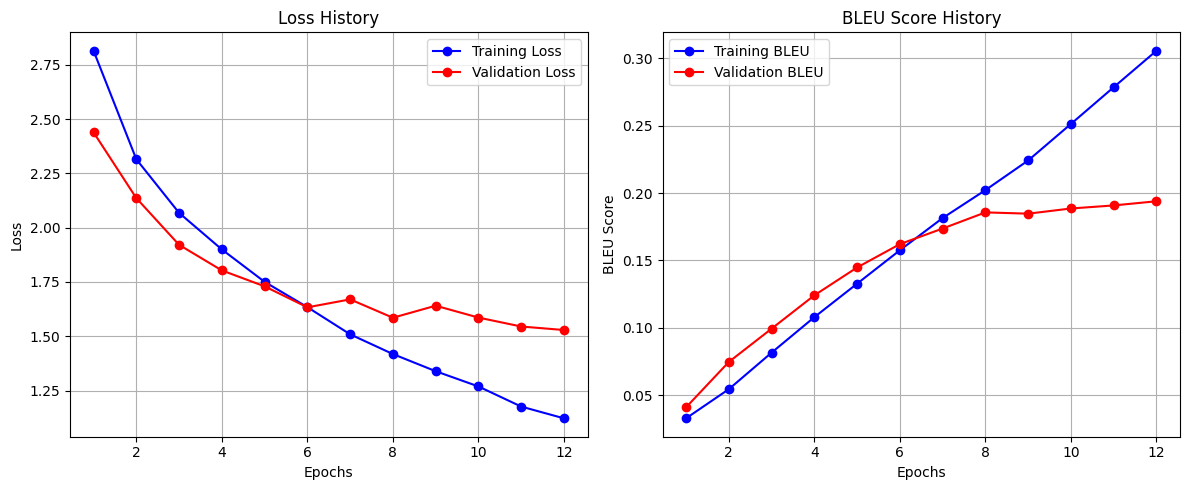

In [25]:
import matplotlib.pyplot as plt
    # --- VẼ BIỂU ĐỒ ---
    # Tách list tổng thành train/val (Vị trí chẵn là Train, lẻ là Val)
train_loss_list = history_loss[0::2]
val_loss_list   = history_loss[1::2]
    
train_bleu_list = history_bleu[0::2]
val_bleu_list   = history_bleu[1::2]
    
epochs_range = range(1, len(train_loss_list) + 1)

plt.figure(figsize=(12, 5))

    # Đồ thị Loss
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_loss_list, 'b-o', label='Training Loss')
plt.plot(epochs_range, val_loss_list, 'r-o', label='Validation Loss')
plt.title('Loss History')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Đồ thị BLEU
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_bleu_list, 'b-o', label='Training BLEU')
plt.plot(epochs_range, val_bleu_list, 'r-o', label='Validation BLEU')
plt.title('BLEU Score History')
plt.xlabel('Epochs')
plt.ylabel('BLEU Score')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# Viết hàm dịch thuật EN - DE

In [26]:
def translate(sentence: str):
    model.eval()
    sentence = normalize_string(sentence)
    # --- Encode sentence ---
    src_ids = Text2ListNum(sentence, en_tokenizer, vocab_src,reverse=True)
    src = torch.tensor([src_ids], dtype=torch.long)    # shape: [1, src_len]
    src = src.to(next(model.parameters()).device)

    with torch.no_grad():
        # input embedding
        embedded_src = model.encoder_embedding(src)     # [1, src_len, emb]

        # Encoder
        _, (h, c) = model.encoder_lstm(embedded_src)

        # Decode
        input_token = torch.tensor([SOS_IDX], device=src.device)
        decoded_ids = []

        for _ in range(50):  # max_len
            emb = model.decoder_embedding(input_token).unsqueeze(0)   # [1,1,emb]
            output, (h, c) = model.decoder_lstm(emb, (h, c))
            logits = model.fc(output.squeeze(0))                      # [1, vocab]
            next_token = logits.argmax(-1)                            # [1]

            token_id = next_token.item()
            decoded_ids.append(token_id)

            if token_id == EOS_IDX:
                break
            
            input_token = next_token # Lấy từ vừa dự đoán làm đầu vào cho vòng lặp sau

        # dùng lookup_tokens thay vì .decode()
        try:
            tokens = vocab_target.lookup_tokens(decoded_ids)
            return " ".join(tokens)
        except AttributeError:
            # Fallback cho phiên bản cũ
            itos = vocab_target.get_itos()
            return " ".join([itos[i] for i in decoded_ids])

        # # Convert IDs → words
        # return vocab_target.decode(decoded_ids)


In [27]:
import random
# --- 1. HÀM ĐÁNH GIÁ TOÀN BỘ TẬP TEST ---
def evaluate_all_test(model, test_loader, device):
    print(f"\n{'='*10} ĐANG CHẠY ĐÁNH GIÁ TRÊN TOÀN BỘ TẬP TEST {'='*10}")
    print(f"Tổng số batch cần xử lý: {len(test_loader)}")
    
    model.eval()
    total_bleu = 0
    total_loss = 0
    criterion = nn.CrossEntropyLoss(ignore_index=PAD_IDX)
    
    with torch.no_grad():
        for i, (src, trg, src_len, trg_len) in enumerate(test_loader):
            src, trg = src.to(device), trg.to(device)

            # Chạy model với teacher_forcing = 0 (tự sinh từ hoàn toàn)
            output = model(src, trg, src_len, trg_len, teacher_forcing_ratio=0)

            # 1. Tính Loss
            output_dim = output.shape[-1]
            loss = criterion(output.view(-1, output_dim), trg.view(-1))
            total_loss += loss.item()

            # 2. Tính BLEU (dùng hàm compute_bleu đã sửa ở trên)
            bleu = compute_bleu(output, trg)
            total_bleu += bleu
            
            # In tiến độ (optional)
            if (i+1) % 10 == 0:
                print(f"-> Đã xong batch {i+1}/{len(test_loader)}")

    avg_loss = total_loss / len(test_loader)
    avg_bleu = total_bleu / len(test_loader)

    print(f"\n{'='*40}")
    print(f"KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST:")
    print(f"Average Loss: {avg_loss:.4f}")
    print(f"Average BLEU: {avg_bleu:.4f} (Thang 0-1)")
    print(f"Average BLEU: {avg_bleu*100:.2f} (Thang 100)")
    print(f"{'='*40}\n")
    return avg_bleu

# --- 2. HÀM HIỂN THỊ MẪU NGẪU NHIÊN ---
def show_random_samples(dataset, model, device, num_samples=20):
    print(f"{'='*10} CÁC MẪU DỊCH NGẪU NHIÊN ({num_samples} CÂU) {'='*10}")
    
    # Lấy index ngẫu nhiên
    indices = random.sample(range(len(dataset)), num_samples)
    
    for idx in indices:
        src_raw, trg_raw = dataset[idx]
        
        # Dùng hàm translate để dịch
        pred_trg = translate(src_raw)
        
        print(f"Mẫu #{idx}:")
        print(f"Input:     {src_raw.strip()}")
        print(f"Target:    {trg_raw.strip()}")
        print(f"Machine:   {pred_trg}")
        print("-" * 60)

In [29]:
test_loader = DataLoader(test_datasets, batch_size=128, shuffle=False, collate_fn=collate_fn)

# 2. Tính điểm số tổng thể
final_score = evaluate_all_test(model, test_loader, device)

# 3. Xem các ví dụ cụ thể
show_random_samples(test_datasets, model, device, num_samples=5)


========== ĐANG CHẠY ĐÁNH GIÁ TRÊN TOÀN BỘ TẬP TEST ==========
Tổng số batch cần xử lý: 9

KẾT QUẢ CUỐI CÙNG TRÊN TẬP TEST:
Average Loss: 4.8230
Average BLEU: 0.1139 (Thang 0-1)
Average BLEU: 11.39 (Thang 100)

========== CÁC MẪU DỊCH NGẪU NHIÊN (5 CÂU) ==========
Mẫu #872:
Input:     woman with hair in her face with green sign in background .
Target:    eine frau mit haaren im gesicht und einem grünen schild im hintergrund .
Machine:   eine frau mit mit einem grünen im im hintergrund . <eos>
------------------------------------------------------------
Mẫu #120:
Input:     a tan dog on a leash walking over a metal grate in the middle of a leaf covered wooden walkway .
Target:    ein hellbrauner hund an der leine läuft über ein metallgitter mitten in einem mit laub bedeckten fußweg .
Machine:   ein gelbbrauner hund auf einer leine über eine leine eines <unk> <unk> in <unk> <unk> . <eos>
------------------------------------------------------------
Mẫu #63:
Input:     three young people 